<img src=../images/logo.png align='right' width=200>

# Smoothing

## Goal
In this notebook we shall examine how Pandas can be used to "smooth" data. This process can help to make trends clearer to visualise.

## Program
- [Exponential smoothing](#es)
- [Filling missing values](#mv)
     - [Assignment](#as3)
- [Weighted smooting](#ws)
- [Expanding windows](#ew)
    - [Assignment](#as4)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Again, we will use the *household power consumption* dataset. It comes from [UCI ML repo](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) and contains detailed power consumption time series data of a single household in Paris between 2006 and 2010.
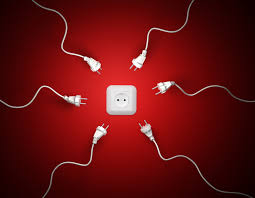

In [ ]:
power = pd.read_csv('../data/household_power_consumption.csv', parse_dates=['ts'], index_col='ts')
power_daily = power.resample('D').sum()
power_daily.head()

Let us have a closer look at the power consumption patterns during a single year.

In [ ]:
power_daily2008 = power_daily.loc['2008']

<a id='es'></a>
## Exponential Smoothing

An alternative to calculating the rolling statistics is to smooth the timeseries exponentially with the following formula:

$$\hat{y_t} = \alpha y_t + (1-\alpha) \hat{y}_{t-1}$$

where $\hat{y_t}$ is the output of the exponential smoothing at time $t$, $y_t$ is the data point at time $t$, and $0<\alpha<1$ is the *the smoothing factor*.


The idea is to recursively smooth the series by averaging the current average with the current value. If $\alpha$ is high then the smoothing will be low but the average can respond quicker to changes, and if it is low — the result will be much more smooth and flat.

In [ ]:
(
    power_daily2008
    .assign(
        smoothed_01=lambda df: df['consumption'].ewm(alpha=0.1).mean(),
        smoothed_001=lambda df: df['consumption'].ewm(alpha=0.01).mean()
    )
    .plot(figsize=(16, 4))
);

Exponential Smoothing exhibits reduced lagging and more weight assigned to the current timestamps compared to Simple Rolling Averages, which also makes it more informative about the future

See more about ewm (exponentially weighted function) on the pandas [docs].

[docs]: https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

<a id='mv'></a>
## Filling Missing Values

Often we may be missing data for some of the timestamps. In such cases these smoothing functions can be especially useful — they can help us fill the missings

In [ ]:
rng = np.random.RandomState(982)
october = power_daily.loc['2007-10']

In [ ]:
n =  october.shape[0]
random_points = rng.rand(n) < 0.2

In [ ]:
power_na = (
   october
    .assign(
        data= lambda df: np.where(random_points, np.NaN, df['consumption']),
        missing_vals = lambda df: np.where(random_points, df['consumption'], np.NaN),
        smooth=lambda df: df['data'].ewm(alpha=0.5).mean().fillna(method='ffill'),
        interpolate_smooth=lambda df: np.where(random_points, df['smooth'], np.NaN)
    )
)
power_na.head(10)

In [ ]:
fig, (ax_top, ax_upper, ax_middle, ax_lower) = plt.subplots(4, figsize=(10, 8), sharex=True)

power_na.plot(y='data', style='.b', ax=ax_top, legend=False)
ax_top.set_title('we recieve a dataset with some missing values.')

power_na.plot(y='data', style='.b', ax=ax_upper, legend=False)
power_na.plot(y='missing_vals', style='.r', ax=ax_upper, legend=False)
ax_upper.set_title('the red values are the true missing values')

power_na.plot(y='data', style='.b', ax=ax_middle, legend=False)
power_na.plot(y='smooth', style='.g', ax=ax_middle, legend=False)
ax_middle.set_title('the green values are from smoothing')

power_na.plot(y='data', style='.b', ax=ax_lower, legend=False)
power_na.plot(y='missing_vals', style='.r', ax=ax_lower, legend=False)
power_na.plot(y='interpolate_smooth', style='.g', ax=ax_lower, legend=False)
ax_lower.set_title('We can compare the true values with our predictions')

for ax in (ax_top, ax_upper, ax_middle, ax_lower):
    ax.set_ylim([0, 25_000])
    ax.set_yticks(range(0, 30_000, 5_000))

fig.tight_layout()

<a id='as3'></a>
## Assignment: fill missing values

First find the days which have __all values__ missing. 

**Note**: 
- use `power` not `power_daily`
- `.sum()` after `.resample('D')` converts missing values (`nan`) to zero

In [ ]:
# %load ../answers/power_daily_na.py

Secondly, pick a month and fill the `na` values by smoothing. 

**Hint: in '2010-08' some days have missing values**

In [ ]:
# %load ../answers/power_daily_na_filled.py

<a id='ws'></a>
## Weighted Smoothing

One interpretation of a rolling window is that you are smoothing the original time series; in other words, we might be 'de-noiseing' the dataset. One advanced setting that is worth mentioning is the window type. By setting the window type to be `gaussian` you can make the smoothing weighted. This way points that are further away have less influence. Another interpretation of this method is that we apply a convolution on the timeseries.

Extra documentation on this topic can be found [here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#rolling-windows) and a demo can be seen below.

Be sure to check the [Wikipedia] page on the topic.

[Wikipedia]: https://en.wikipedia.org/wiki/Window_function#Gaussian_window

In [ ]:
(
    power_daily2008
    .assign(
        rolling_gaussian_mean=lambda df: (
            df['consumption']
            .rolling(30, center=True, win_type='gaussian')
            .mean(std=5)
        ),
        rolling_standard_mean=lambda df: df['consumption'].rolling(30, center=True).mean(),
    )
    .plot(figsize=(16, 4))
);

## Expanding Windows

A common alternative to rolling statistics are expanding windows `.expanding()`. An expanding window yields the value of the statistic with **all the data available up to that point in time**. In essense, this allows you to write functions like `cumsum()` but with more customisation options.

In [ ]:
(
    power_daily
    .assign(cumsum=lambda df: df['consumption'].cumsum(),
            expanding=lambda df: df.expanding()['consumption'].sum())
    .head(6)
)

In [ ]:
#running minimum and maximum
(
    power_daily
    .assign(running_minimum=lambda df: df.expanding()['consumption'].min(),
            running_maximum=lambda df: df.expanding()['consumption'].max())
    .head(6)
)

You can write your own aggregation functions as you wish.

In [ ]:
def cum_mean(array):
    #print(array)
    return np.mean(array)

power_daily.head(4).expanding().apply(cum_mean, raw=True)

## Assignment: Detecting Holidays

We can identify holidays as periods when power consumption drops significantly for a few days.

Find all periods (start and end dates) that are at least 5 days long and have total energy consumption in **each day** below 5000 watt-hour.

*you can load the answer below:*

In [ ]:
# %load ../answers/power_holidays.py